# Neural network vs Poisson regression

This notebooks applies and compares the Poisson regression methodology and the more complex multilayered perceptron model with an asumption of a Poisson distirbution for the output variable to fit the data of the Bicycle Counts for East River Bridges (https://data.cityofnewyork.us/Transportation/Bicycle-Counts-for-East-River-Bridges-Historical-/gua4-p9wg) which is a public data set with the daily total of bike counts conducted monthly on the Brooklyn Bridge, Manhattan Bridge, Willaimsburg Bridge, and Queensboro Bridge.

In [30]:
import os
import sys

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

home_path = os.path.dirname(os.getcwd())
sys.path.append(home_path)

from PoissonRegression.PoissonRegression import PoissonRegression



## Data preproccessing

In [7]:
data = pd.read_csv(
    'nyc_bb_bicyclist_counts.csv',
    header=0, 
    infer_datetime_format=True, 
    parse_dates=[0], 
    index_col=[0]
)
data.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807


In [10]:
dates = data.index.to_series()
data['MONTH'] = dates.dt.month
data['DAY_OF_WEEK'] = dates.dt.day_of_week
data['DAY'] = dates.dt.day

In [36]:
data.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5


In [37]:
y = data.to_numpy()[:,3]
X = np.delete(data.to_numpy(), 3, axis = 1)

In [41]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:
y_train

array([3190., 3169., 3679.,  836., 2657., 2983., 2727., 1876., 2199.,
       3048., 3766., 2673., 2687., 3367., 3211., 3386., 2744., 1576.,
       3130., 3821., 3287., 2253., 3312., 3297., 2609., 3387., 2590.,
       3637., 2969., 2840., 1472., 3688., 3170.,  151., 3415.,  461.,
       2411., 2750., 2952., 3296., 1193., 2169., 3356.,  488., 2860.,
       3346., 2853., 2718., 3216., 2565., 3353., 3276., 3148., 2721.,
       2945., 3013., 3234., 3304., 2021., 1428., 2942., 1235., 3368.,
       3189.,  898., 3666., 2074., 2563., 3539., 3317., 2869., 2994.,
       2637., 3331.,  183., 2012., 3412., 3510., 1318., 1848., 3497.,
       2470., 3066., 2625., 4960., 1222., 3421., 3344., 1399., 2321.,
       2171., 3535., 2596., 2467., 1004., 3182., 2710., 3887., 3342.,
       2149., 2283., 2560., 3506., 2400., 2544., 3409., 3324., 2297.,
        907., 3657., 3291., 2751., 3265., 1805., 2877., 2640., 2543.,
       3114., 3407., 3174., 2959., 2054., 1452.,  611.,  723., 1903.,
       2161., 3332.,

## Poisson regression model

In [43]:
pr_model = PoissonRegression()
pr_model.fit(X_train, y_train)

In [44]:
y_pred_pr = pr_model.predict(X_test)
y_pred_pr_int = pr_model.predict(X_test, as_integers=True)

print(mean_squared_error(y_test, y_pred_pr))
print(mean_squared_error(y_test, y_pred_pr_int))

304356.48309221194
304324.6511627907


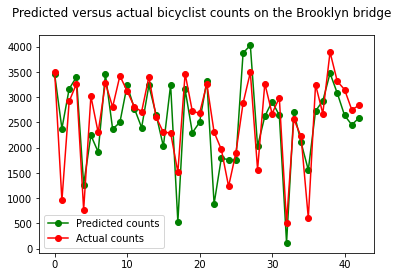

In [45]:
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(y_pred_pr_int, 'go-', label='Predicted counts')
actual, = plt.plot(y_test, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

## Neural network model

In [99]:
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, input_shape=(X_train.shape[1],), activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = tf.exp)
])

nn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 8)                 56        
                                                                 
 dense_33 (Dense)            (None, 16)                144       
                                                                 
 dense_34 (Dense)            (None, 32)                544       
                                                                 
 dense_35 (Dense)            (None, 16)                528       
                                                                 
 dense_36 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,289
Trainable params: 1,289
Non-trainable params: 0
_________________________________________________________________


In [105]:
nn_model.compile(
    optimizer='adam',
    loss='poisson'
)

hist = nn_model.fit(
    X_train, 
    y_train,
    batch_size = 32, 
    epochs = 1000, 
    verbose = 0,
    validation_split = 0.2
)

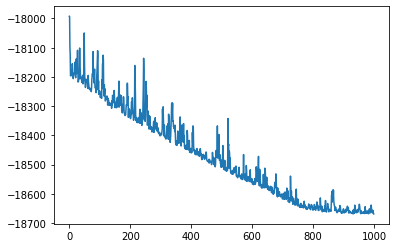

In [106]:
plt.plot(hist.history['loss'])
plt.show()

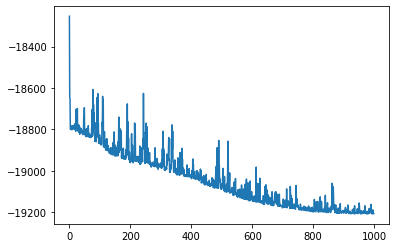

In [107]:
plt.plot(hist.history['val_loss'])
plt.show()

In [108]:
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_int = np.round(nn_model.predict(X_test))

print(mean_squared_error(y_test, y_pred_nn))
print(mean_squared_error(y_test, y_pred_nn_int))

215841.7570766104
215841.67441860464


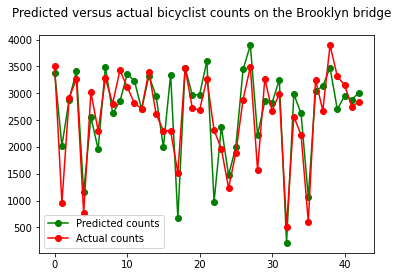

In [109]:
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(y_pred_nn_int, 'go-', label='Predicted counts')
actual, = plt.plot(y_test, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()